In [ ]:
! pip install langchain_openai
! pip install langchain_community

In [ ]:
! pip install langgraph

# Summary of the LangGraph for Root Cause Analysis

This Python code uses LangGraph and LangChain to create an agent capable of analyzing the reasons why an account is aligned to a specific territory. Here's a summary of the main components and how they work:

## Objective

The main objective is to allow users to ask questions in natural language (e.g., "Why is account 123 aligned to territory ABC?") and receive a clear and concise explanation.

## Key Components

* **`call_apex` Function:**
    * This function simulates a call to an Apex class (in a Salesforce environment). In a real-world context, it would be replaced by the actual call to your Apex logic.
* **LangChain Tool `root_cause_analysis_tool`:**
    * This tool encapsulates the `call_apex` function and makes it accessible to the language model.
* **Language Model `model`:**
    * An OpenAI model is used to process questions and generate natural language responses. It is configured to use the defined tools.
* **LangGraph `graph`:**
    * The graph defines the agent's workflow. It includes the following nodes:
        * **`extract_entities`:** Extracts account and territory IDs from the user's question.
        * **`call_tool`:** Calls the `root_cause_analysis_tool` with the extracted IDs.
        * **`generate_response`:** Generates a natural language response based on the tool's result.
* **Graph Visualization:**
    * The code includes a feature to visualize the LangGraph using `IPython.display` and `graph.get_graph().draw_mermaid_png()`.

## Workflow

1.  The user asks a question in natural language.
2.  The `extract_entities` node extracts the account and territory IDs.
3.  The `call_tool` node calls the `root_cause_analysis_tool`, which in turn calls the `call_apex` function.
4.  The `generate_response` node uses the language model to generate a natural language response.
5.  The response is displayed to the user.

## Usage

To use this code, you will need to:

* Replace the `call_apex` function with the call to your Apex logic.
* Install the necessary dependencies (LangChain, LangGraph, OpenAI, etc.).
* Run the code in a Jupyter environment or similar.

This code provides a solid foundation for building an agent capable of analyzing and explaining account alignments to territories, using tools and language models.


In [18]:
from langgraph.graph import StateGraph, END
from typing import Dict, List, TypedDict, Annotated
import operator
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.runnables import RunnableLambda
from langchain_core.agents import AgentActionMessageLog, AgentFinish
import json


In [19]:
import os
from langchain_openai import ChatOpenAI

os.environ['OPENAI_API_KEY'] = "sk-proj- A"


llm_apex = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

In [27]:
def call_apex(account_id: str, territory_id: str) -> str:
    """
    Calls the Apex class for root cause analysis.
    Replace this with the actual call to your Apex class.
    """
    # Here, you need to integrate the actual call to your Apex class.
    # For the example, we simulate a response.
    return f"Account {account_id} is aligned to territory {territory_id} due to factors X, Y, and Z."

# LangChain Tool to call the Apex class
def root_cause_analysis_func(account_id: str, territory_id: str) -> str:
    return call_apex(account_id, territory_id)

root_cause_analysis_tool = Tool(
    name="root_cause_analysis",
    func=root_cause_analysis_func,
    description="Performs a root cause analysis to explain the alignment of an account to a territory."
)

tools = [root_cause_analysis_tool]
tool_map = {tool.name: tool for tool in tools}

In [32]:
class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    account_id: str
    territory_id: str
    tool_input: Dict
    tool_output: str

def extract_entities(state: GraphState):
    """Extracts account and territory IDs from the question."""
    question = state['messages'][-1].content # last message
    # Here, you will need to implement logic to extract account and territory IDs
    # from the question.
    # For the example, we simulate them.
    account_id = "123"
    territory_id = "ABC"
    return {"account_id": account_id, "territory_id": territory_id, "messages": state["messages"]}

def call_tool(state: GraphState):
    """Calls the root cause analysis tool."""
    messages = state['messages']
    response = llm_apex.invoke(messages)

    if response.additional_kwargs and "tool_calls" in response.additional_kwargs:
        tool_calls = response.additional_kwargs["tool_calls"]
        tool_name = tool_calls[0]["function"]["name"]
        tool_arguments = json.loads(tool_calls[0]["function"]["arguments"])
        tool_output = tool_map[tool_name].func(**tool_arguments) # direct function call
        return {"messages": messages + [AIMessage(content=tool_output)], "tool_output": tool_output}
    else:
        return {"messages": messages + [response]}

def generate_response(state: GraphState):
    """Generates a natural language response."""
    messages = state['messages']
    response = llm_apex.invoke(messages)
    return {"messages": messages + [response]}

In [33]:
# Graph construction
graph_builder = StateGraph(GraphState)
graph_builder.add_node("extract_entities", extract_entities)
graph_builder.add_node("call_tool", call_tool)
graph_builder.add_node("generate_response", generate_response)

graph_builder.add_edge("extract_entities", "call_tool")
graph_builder.add_edge("call_tool", "generate_response")
graph_builder.set_entry_point("extract_entities")
graph_builder.add_edge("generate_response", END)

graph = graph_builder.compile()

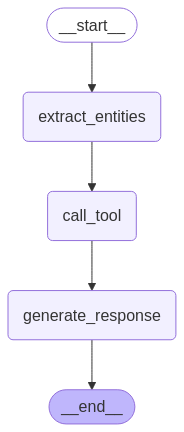

In [34]:
# Graph visualization
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error generating graph: {e}")
    # This requires some extra dependencies and is optional
    pass


In [35]:
# Example usage
inputs = {"messages": [HumanMessage(content="Why is account 123 aligned to territory ABC ?")]}
for output in graph.stream(inputs):
    for key, value in output.items():
        if key == "generate_response":
            messages = value['messages']
            for message in messages:
                if isinstance(message, AIMessage):
                    print(message.content)

The alignment of account 123 to territory ABC could be due to several factors, including:

1. **Geographic Location**: Account 123 may be located within the geographic boundaries defined for territory ABC.

2. **Market Segmentation**: The account might fit the target market or customer profile that territory ABC is designed to serve.

3. **Sales Strategy**: The alignment could be part of a broader sales strategy to optimize resources and focus on specific accounts that are likely to yield higher returns in territory ABC.

4. **Historical Performance**: If account 123 has previously shown strong engagement or sales performance in territory ABC, it may have been strategically aligned there to capitalize on that success.

5. **Account Size or Potential**: The size or potential of account 123 may warrant its inclusion in territory ABC, especially if it aligns with the goals of that territory.

6. **Team Expertise**: The sales team or representatives assigned to territory ABC may have speci